In [2]:
import pandas as pd
import numpy as np
import keras
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import h5py
from tqdm import tqdm
import warnings

In [3]:
def load_data(filepath):
    # Load data from H5 file
    data = h5py.File(filepath, 'r')

    # Extract features and labels
    features = np.array(data['data']).transpose((0, 2, 3, 1))
    labels = np.array(data['label'])

    # Close the H5 file
    data.close()

    return features, labels

In [4]:
# Filepaths for clean and poisoned data, and the BadNet model
clean_data_filepath = r'valid.h5'
poisoned_data_filepath = r'bd_valid.h5'
badnet_model_filepath = r'bd_net.h5'

In [5]:
# Load clean and poisoned data
clean_x_test, clean_y_test = load_data(clean_data_filepath)
poisoned_x_test, poisoned_y_test = load_data(poisoned_data_filepath)

# Load the BadNet model
badnet_model = keras.models.load_model(badnet_model_filepath)

# Evaluate BadNet on clean data
clean_predictions = np.argmax(badnet_model.predict(clean_x_test), axis=1)
clean_classification_accuracy = np.mean(np.equal(clean_predictions, clean_y_test)) * 100
print('Classification Accuracy -> ', clean_classification_accuracy)

# Evaluate BadNet on poisoned data
poisoned_predictions = np.argmax(badnet_model.predict(poisoned_x_test), axis=1)
attack_success_rate = np.mean(np.equal(poisoned_predictions, poisoned_y_test)) * 100
print('Attack Success Rate -> ', attack_success_rate)

361/361 [==============================] - 2s 5ms/step
Classification Accuracy ->  98.64899974019225
361/361 [==============================] - 2s 5ms/step
Attack Success Rate ->  100.0


In [6]:
# Load the BadNet model from the specified file
model = keras.models.load_model(badnet_model_filepath)

# Print a summary of the BadNet model architecture
print('BadNet Model Summary:')
print(model.summary())

BadNet Model Summary:
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, 55, 47, 3)]          0         []                            
                                                                                                  
 conv_1 (Conv2D)             (None, 52, 44, 20)           980       ['input[0][0]']               
                                                                                                  
 pool_1 (MaxPooling2D)       (None, 26, 22, 20)           0         ['conv_1[0][0]']              
                                                                                                  
 conv_2 (Conv2D)             (None, 24, 20, 40)           7240      ['pool_1[0][0]']              
                                                                      

The summary provides information about the layers, parameters, and output shapes of the model.

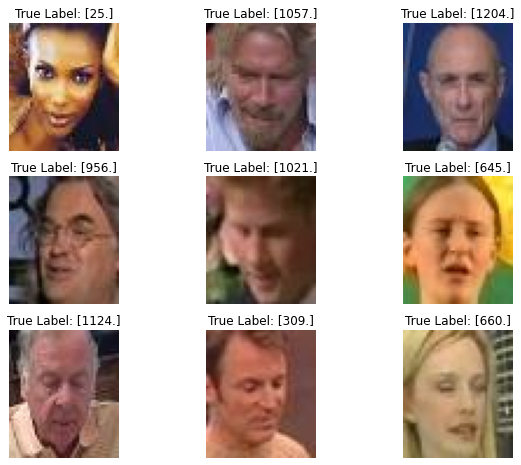

In [7]:
# Load data using the data_loader function
images, labels = load_data(clean_data_filepath)

# Create a figure to display a grid of random images and their true labels
figure = plt.figure(figsize=(10, 8))
num_cols, num_rows = 3, 3  # Set the number of columns and rows for the grid

# Display random images with their true labels
for i in range(1, num_cols * num_rows + 1):
    random_index = np.random.randint(images.shape[0], size=1)

    # Extract the image and label at the random index
    image, label = (images[random_index], labels[random_index])

    figure.add_subplot(num_rows, num_cols, i)

    # Set the title with the true label
    plt.title("True Label: {}".format(label))
    plt.axis("off")

    # Display the image (assuming values are in the range [0, 255])
    plt.imshow(image[0] / 255)

# Show the grid of images
plt.show()

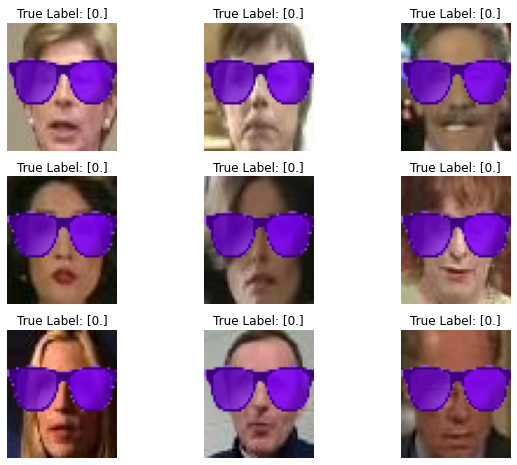

In [8]:
# Load poisoned data using the data_loader function
poisoned_images, poisoned_labels = load_data(poisoned_data_filepath)

# Create a figure to display a grid of random poisoned images and their true labels
figure = plt.figure(figsize=(10, 8))
num_cols, num_rows = 3, 3  # Set the number of columns and rows for the grid

# Display random poisoned images with their true labels
for i in range(1, num_cols * num_rows + 1):
    random_index = np.random.randint(poisoned_images.shape[0], size=1)

    # Extract the poisoned image and label at the random index
    poisoned_image, poisoned_label = (poisoned_images[random_index], poisoned_labels[random_index])

    figure.add_subplot(num_rows, num_cols, i)

    # Set the title with the true label
    plt.title("True Label: {}".format(poisoned_label))
    plt.axis("off")

    # Display the poisoned image (assuming values are in the range [0, 255])
    plt.imshow(poisoned_image[0] / 255)

# Show the grid of poisoned images
plt.show()

In [9]:
# clearing the session
keras.backend.clear_session()

In [10]:
# Load clean data using the load_data function
clean_images, clean_labels = load_data(clean_data_filepath)

In [11]:
# Load poisoned data using the load_data function
poisoned_images, poisoned_labels = load_data(poisoned_data_filepath)

In [12]:
# Clean data accuracy
clean_data_accuracy = 98.64899974019225

# Create a copy of the model using keras.models.clone_model
copied_model = keras.models.clone_model(model)

# Set the weights of the copied model to be the same as the original model
copied_model.set_weights(model.get_weights())

# Initialize lists to store pruning indices, clean accuracies, and attack success rates
prune_indices = []
clean_accuracies = []
attack_success_rates = []

# Initialize an array to track whether the model is saved at different points
saved_model_flags = np.zeros(3, dtype=bool)

In [13]:
# Get the output of the 'pool_3' layer from the copied model
pool_3_output = copied_model.get_layer('pool_3').output

# Create an intermediate model that outputs the 'pool_3' layer output
intermediate_model = keras.models.Model(inputs=copied_model.input, outputs=pool_3_output)

# Predict using the intermediate model on the clean data
intermediate_predictions = intermediate_model.predict(clean_x_test)

# Calculate the mean of the intermediate predictions along spatial dimensions
mean_intermediate_predictions = np.mean(intermediate_predictions, axis=(0, 1, 2))

# Get the indices of the sorted mean values
sorted_indices = np.argsort(mean_intermediate_predictions)

# Get the weights and bias of the layer at index 5 in the copied model
weights_layer_5 = copied_model.layers[5].get_weights()[0]
bias_layer_5 = copied_model.layers[5].get_weights()[1]

361/361 [==============================] - 1s 4ms/step


In [14]:
# Iterate through channels in sorted order
for channel_index in tqdm(sorted_indices):
    # Set weights and bias of the layer at index 5 to zero for the current channel
    weights_layer_5[:, :, :, channel_index] = 0
    bias_layer_5[channel_index] = 0

    # Set the modified weights and bias in the copied model
    copied_model.layers[5].set_weights([weights_layer_5, bias_layer_5])

    # Predict on clean data with the modified model
    clean_label_predictions = np.argmax(copied_model.predict(clean_x_test), axis=1)

    # Calculate clean accuracy
    clean_accuracy = np.mean(np.equal(clean_label_predictions, clean_y_test)) * 100

    # Check for accuracy drops and save the model accordingly
    for drop_threshold, saved_flag_index in zip([2, 4, 10], range(3)):
        if (clean_data_accuracy - clean_accuracy >= drop_threshold and not saved_model_flags[saved_flag_index]):
            print(f"Model saved; Least drop in accuracy: {drop_threshold}%.")
            copied_model.save(f'model_X={drop_threshold}.h5')
            saved_model_flags[saved_flag_index] = 1

    # Append clean accuracy to the list
    clean_accuracies.append(clean_accuracy)

    # Predict on poisoned data with the modified model
    poisoned_label_predictions = np.argmax(copied_model.predict(poisoned_x_test), axis=1)

    # Calculate attack success rate
    attack_success_rate = np.mean(np.equal(poisoned_label_predictions, poisoned_y_test)) * 100

    # Append attack success rate to the list
    attack_success_rates.append(attack_success_rate)

    # Print relevant information
    print("Clean Classification Accuracy -> ", clean_accuracy)
    print("Attack Success Rate -> ", attack_success_rate)
    print("Index of Pruned Channel -> ", channel_index)
    print()

    # Clear the Keras backend session to release memory
    keras.backend.clear_session()

  0%|          | 0/60 [00:00<?, ?it/s]

361/361 [==============================] - 2s 5ms/step


  2%|▏         | 1/60 [00:05<05:20,  5.43s/it]

Clean Classification Accuracy ->  98.64899974019225
Attack Success Rate ->  100.0
Index of Pruned Channel ->  0

361/361 [==============================] - 2s 5ms/step


  3%|▎         | 2/60 [00:10<05:08,  5.32s/it]

Clean Classification Accuracy ->  98.64899974019225
Attack Success Rate ->  100.0
Index of Pruned Channel ->  26

361/361 [==============================] - 2s 5ms/step
Clean Classification Accuracy ->  98.64899974019225
Attack Success Rate ->  100.0
Index of Pruned Channel ->  27



  5%|▌         | 3/60 [00:15<05:00,  5.28s/it]

361/361 [==============================] - 2s 5ms/step
Clean Classification Accuracy ->  98.64899974019225
Attack Success Rate ->  100.0
Index of Pruned Channel ->  30



  7%|▋         | 4/60 [00:21<04:55,  5.28s/it]

361/361 [==============================] - 2s 5ms/step
Clean Classification Accuracy ->  98.64899974019225
Attack Success Rate ->  100.0
Index of Pruned Channel ->  31



  8%|▊         | 5/60 [00:26<04:49,  5.26s/it]

361/361 [==============================] - 2s 5ms/step


 10%|█         | 6/60 [00:31<04:47,  5.32s/it]

Clean Classification Accuracy ->  98.64899974019225
Attack Success Rate ->  100.0
Index of Pruned Channel ->  33

361/361 [==============================] - 2s 5ms/step


 12%|█▏        | 7/60 [00:37<04:40,  5.28s/it]

Clean Classification Accuracy ->  98.64899974019225
Attack Success Rate ->  100.0
Index of Pruned Channel ->  34

361/361 [==============================] - 2s 4ms/step


 13%|█▎        | 8/60 [00:42<04:31,  5.22s/it]

Clean Classification Accuracy ->  98.64899974019225
Attack Success Rate ->  100.0
Index of Pruned Channel ->  36

361/361 [==============================] - 2s 5ms/step


 15%|█▌        | 9/60 [00:47<04:25,  5.20s/it]

Clean Classification Accuracy ->  98.64899974019225
Attack Success Rate ->  100.0
Index of Pruned Channel ->  37

361/361 [==============================] - 2s 5ms/step


 17%|█▋        | 10/60 [00:52<04:19,  5.20s/it]

Clean Classification Accuracy ->  98.64899974019225
Attack Success Rate ->  100.0
Index of Pruned Channel ->  38

361/361 [==============================] - 2s 4ms/step


 18%|█▊        | 11/60 [00:57<04:13,  5.18s/it]

Clean Classification Accuracy ->  98.64899974019225
Attack Success Rate ->  100.0
Index of Pruned Channel ->  25

361/361 [==============================] - 2s 5ms/step


 20%|██        | 12/60 [01:02<04:08,  5.17s/it]

Clean Classification Accuracy ->  98.64899974019225
Attack Success Rate ->  100.0
Index of Pruned Channel ->  39

361/361 [==============================] - 2s 5ms/step


 22%|██▏       | 13/60 [01:07<04:02,  5.15s/it]

Clean Classification Accuracy ->  98.64899974019225
Attack Success Rate ->  100.0
Index of Pruned Channel ->  41

361/361 [==============================] - 2s 5ms/step


 23%|██▎       | 14/60 [01:13<03:58,  5.17s/it]

Clean Classification Accuracy ->  98.64899974019225
Attack Success Rate ->  100.0
Index of Pruned Channel ->  44

361/361 [==============================] - 2s 5ms/step


 25%|██▌       | 15/60 [01:18<03:53,  5.19s/it]

Clean Classification Accuracy ->  98.64899974019225
Attack Success Rate ->  100.0
Index of Pruned Channel ->  45

361/361 [==============================] - 2s 4ms/step


 27%|██▋       | 16/60 [01:23<03:49,  5.21s/it]

Clean Classification Accuracy ->  98.64899974019225
Attack Success Rate ->  100.0
Index of Pruned Channel ->  47

361/361 [==============================] - 2s 5ms/step
Clean Classification Accuracy ->  98.64899974019225
Attack Success Rate ->  100.0
Index of Pruned Channel ->  48



 28%|██▊       | 17/60 [01:28<03:44,  5.21s/it]

361/361 [==============================] - 2s 5ms/step


 30%|███       | 18/60 [01:34<03:39,  5.22s/it]

Clean Classification Accuracy ->  98.64899974019225
Attack Success Rate ->  100.0
Index of Pruned Channel ->  49

361/361 [==============================] - 2s 5ms/step


 32%|███▏      | 19/60 [01:39<03:34,  5.23s/it]

Clean Classification Accuracy ->  98.64899974019225
Attack Success Rate ->  100.0
Index of Pruned Channel ->  50

361/361 [==============================] - 2s 5ms/step
Clean Classification Accuracy ->  98.64899974019225
Attack Success Rate ->  100.0
Index of Pruned Channel ->  53



 33%|███▎      | 20/60 [01:44<03:29,  5.24s/it]

361/361 [==============================] - 2s 4ms/step


 35%|███▌      | 21/60 [01:49<03:24,  5.23s/it]

Clean Classification Accuracy ->  98.64899974019225
Attack Success Rate ->  100.0
Index of Pruned Channel ->  55

361/361 [==============================] - 2s 5ms/step
Clean Classification Accuracy ->  98.64899974019225

 37%|███▋      | 22/60 [01:55<03:18,  5.23s/it]


Attack Success Rate ->  100.0
Index of Pruned Channel ->  40

361/361 [==============================] - 2s 5ms/step


 38%|███▊      | 23/60 [02:00<03:13,  5.23s/it]

Clean Classification Accuracy ->  98.64899974019225
Attack Success Rate ->  100.0
Index of Pruned Channel ->  24

361/361 [==============================] - 2s 5ms/step


 40%|████      | 24/60 [02:05<03:09,  5.26s/it]

Clean Classification Accuracy ->  98.64899974019225
Attack Success Rate ->  100.0
Index of Pruned Channel ->  59

361/361 [==============================] - 2s 5ms/step


 42%|████▏     | 25/60 [02:10<03:03,  5.26s/it]

Clean Classification Accuracy ->  98.64899974019225
Attack Success Rate ->  100.0
Index of Pruned Channel ->  9

361/361 [==============================] - 2s 4ms/step


 43%|████▎     | 26/60 [02:16<02:58,  5.25s/it]

Clean Classification Accuracy ->  98.64899974019225
Attack Success Rate ->  100.0
Index of Pruned Channel ->  2

361/361 [==============================] - 2s 5ms/step


 45%|████▌     | 27/60 [02:21<02:53,  5.26s/it]

Clean Classification Accuracy ->  98.64899974019225
Attack Success Rate ->  100.0
Index of Pruned Channel ->  12

361/361 [==============================] - 2s 5ms/step


 47%|████▋     | 28/60 [02:26<02:48,  5.25s/it]

Clean Classification Accuracy ->  98.64899974019225
Attack Success Rate ->  100.0
Index of Pruned Channel ->  13

361/361 [==============================] - 2s 5ms/step


 48%|████▊     | 29/60 [02:31<02:42,  5.25s/it]

Clean Classification Accuracy ->  98.64899974019225
Attack Success Rate ->  100.0
Index of Pruned Channel ->  17

361/361 [==============================] - 2s 5ms/step


 50%|█████     | 30/60 [02:37<02:37,  5.24s/it]

Clean Classification Accuracy ->  98.64899974019225
Attack Success Rate ->  100.0
Index of Pruned Channel ->  14

361/361 [==============================] - 2s 5ms/step


 52%|█████▏    | 31/60 [02:42<02:31,  5.24s/it]

Clean Classification Accuracy ->  98.64899974019225
Attack Success Rate ->  100.0
Index of Pruned Channel ->  15

361/361 [==============================] - 2s 5ms/step
Clean Classification Accuracy ->  98.64899974019225
Attack Success Rate ->  100.0
Index of Pruned Channel ->  23



 53%|█████▎    | 32/60 [02:47<02:26,  5.24s/it]

361/361 [==============================] - 2s 5ms/step


 55%|█████▌    | 33/60 [02:52<02:21,  5.25s/it]

Clean Classification Accuracy ->  98.64899974019225
Attack Success Rate ->  100.0
Index of Pruned Channel ->  6

361/361 [==============================] - 2s 5ms/step


 57%|█████▋    | 34/60 [02:58<02:16,  5.24s/it]

Clean Classification Accuracy ->  98.64033948211657
Attack Success Rate ->  100.0
Index of Pruned Channel ->  51

361/361 [==============================] - 2s 5ms/step


 58%|█████▊    | 35/60 [03:03<02:10,  5.24s/it]

Clean Classification Accuracy ->  98.64033948211657
Attack Success Rate ->  100.0
Index of Pruned Channel ->  32

361/361 [==============================] - 2s 5ms/step


 60%|██████    | 36/60 [03:08<02:05,  5.24s/it]

Clean Classification Accuracy ->  98.63167922404088
Attack Success Rate ->  100.0
Index of Pruned Channel ->  22

361/361 [==============================] - 2s 5ms/step


 62%|██████▏   | 37/60 [03:13<02:00,  5.24s/it]

Clean Classification Accuracy ->  98.65765999826795
Attack Success Rate ->  100.0
Index of Pruned Channel ->  21

361/361 [==============================] - 2s 5ms/step


 63%|██████▎   | 38/60 [03:19<01:55,  5.25s/it]

Clean Classification Accuracy ->  98.64899974019225
Attack Success Rate ->  100.0
Index of Pruned Channel ->  20

361/361 [==============================] - 2s 5ms/step
Clean Classification Accuracy ->  98.6056984498138
Attack Success Rate ->  100.0
Index of Pruned Channel ->  19



 65%|██████▌   | 39/60 [03:24<01:50,  5.26s/it]

361/361 [==============================] - 2s 5ms/step


 67%|██████▋   | 40/60 [03:29<01:45,  5.25s/it]

Clean Classification Accuracy ->  98.57105741751104
Attack Success Rate ->  100.0
Index of Pruned Channel ->  43

361/361 [==============================] - 2s 5ms/step


 68%|██████▊   | 41/60 [03:34<01:39,  5.25s/it]

Clean Classification Accuracy ->  98.53641638520828
Attack Success Rate ->  100.0
Index of Pruned Channel ->  58

361/361 [==============================] - 2s 5ms/step


 70%|███████   | 42/60 [03:39<01:34,  5.24s/it]

Clean Classification Accuracy ->  98.19000606218066
Attack Success Rate ->  100.0
Index of Pruned Channel ->  3

361/361 [==============================] - 2s 5ms/step


 72%|███████▏  | 43/60 [03:45<01:29,  5.24s/it]

Clean Classification Accuracy ->  97.65307006148784
Attack Success Rate ->  100.0
Index of Pruned Channel ->  42

361/361 [==============================] - 2s 5ms/step


 73%|███████▎  | 44/60 [03:50<01:23,  5.24s/it]

Clean Classification Accuracy ->  97.50584567420108
Attack Success Rate ->  100.0
Index of Pruned Channel ->  1

361/361 [==============================] - 2s 5ms/step
Model saved; Least drop in accuracy: 2%.


/home/jpr8961/.local/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


361/361 [==============================] - 2s 5ms/step


 75%|███████▌  | 45/60 [03:55<01:19,  5.27s/it]

Clean Classification Accuracy ->  95.75647354291158
Attack Success Rate ->  100.0
Index of Pruned Channel ->  29

361/361 [==============================] - 2s 5ms/step
Clean Classification Accuracy ->  95.20221702606739
Attack Success Rate ->  99.9913397419243
Index of Pruned Channel ->  16



 77%|███████▋  | 46/60 [04:01<01:13,  5.27s/it]

361/361 [==============================] - 2s 5ms/step


 78%|███████▊  | 47/60 [04:06<01:09,  5.33s/it]

Clean Classification Accuracy ->  94.7172425738287
Attack Success Rate ->  99.9913397419243
Index of Pruned Channel ->  56

361/361 [==============================] - 2s 5ms/step
Model saved; Least drop in accuracy: 4%.
361/361 [==============================] - 2s 5ms/step


 80%|████████  | 48/60 [04:11<01:03,  5.32s/it]

Clean Classification Accuracy ->  92.09318437689443
Attack Success Rate ->  99.9913397419243
Index of Pruned Channel ->  46

361/361 [==============================] - 2s 5ms/step


 82%|████████▏ | 49/60 [04:17<00:58,  5.30s/it]

Clean Classification Accuracy ->  91.49562656967177
Attack Success Rate ->  99.9913397419243
Index of Pruned Channel ->  5

361/361 [==============================] - 2s 5ms/step


 83%|████████▎ | 50/60 [04:22<00:52,  5.28s/it]

Clean Classification Accuracy ->  91.01931237550879
Attack Success Rate ->  99.98267948384861
Index of Pruned Channel ->  8

361/361 [==============================] - 2s 5ms/step


 85%|████████▌ | 51/60 [04:27<00:47,  5.27s/it]

Clean Classification Accuracy ->  89.17467740538669
Attack Success Rate ->  80.73958603966398
Index of Pruned Channel ->  11

361/361 [==============================] - 2s 4ms/step
Model saved; Least drop in accuracy: 10%.
361/361 [==============================] - 2s 5ms/step
Clean Classification Accuracy ->  84.43751623798389
Attack Success Rate ->  77.015675067117
Index of Pruned Channel ->  54



 87%|████████▋ | 52/60 [04:32<00:42,  5.26s/it]

361/361 [==============================] - 2s 5ms/step


 88%|████████▊ | 53/60 [04:38<00:36,  5.26s/it]

Clean Classification Accuracy ->  76.48739932449988
Attack Success Rate ->  35.71490430414826
Index of Pruned Channel ->  10

361/361 [==============================] - 2s 5ms/step
Clean Classification Accuracy ->  54.8627349095003
Attack Success Rate ->  6.954187234779596
Index of Pruned Channel ->  28



 90%|█████████ | 54/60 [04:43<00:31,  5.26s/it]

361/361 [==============================] - 2s 5ms/step


 92%|█████████▏| 55/60 [04:48<00:26,  5.26s/it]

Clean Classification Accuracy ->  27.08928726076037
Attack Success Rate ->  0.4243526457088421
Index of Pruned Channel ->  35

361/361 [==============================] - 2s 5ms/step


 93%|█████████▎| 56/60 [04:53<00:21,  5.26s/it]

Clean Classification Accuracy ->  13.87373343725643
Attack Success Rate ->  0.0
Index of Pruned Channel ->  18

361/361 [==============================] - 2s 5ms/step


 95%|█████████▌| 57/60 [04:59<00:15,  5.26s/it]

Clean Classification Accuracy ->  7.101411622066338
Attack Success Rate ->  0.0
Index of Pruned Channel ->  4

361/361 [==============================] - 2s 5ms/step


 97%|█████████▋| 58/60 [05:04<00:10,  5.25s/it]

Clean Classification Accuracy ->  1.5501861955486274
Attack Success Rate ->  0.0
Index of Pruned Channel ->  7

361/361 [==============================] - 2s 5ms/step
Clean Classification Accuracy ->  0.7188014202823244
Attack Success Rate ->  0.0
Index of Pruned Channel ->  52



 98%|█████████▊| 59/60 [05:09<00:05,  5.25s/it]

361/361 [==============================] - 2s 5ms/step


100%|██████████| 60/60 [05:14<00:00,  5.25s/it]

Clean Classification Accuracy ->  0.0779423226812159
Attack Success Rate ->  0.0
Index of Pruned Channel ->  57



In [15]:
# Print the list of clean accuracies obtained during pruning
print("Clean Classification Accuracy -> ", clean_accuracies)

# Print the list of attack success rates obtained during pruning
print("Attack Success Rate -> ", attack_success_rates)

Clean Classification Accuracy ->  [98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64033948211657, 98.64033948211657, 98.63167922404088, 98.65765999826795, 98.64899974019225, 98.6056984498138, 98.57105741751104, 98.53641638520828, 98.19000606218066, 97.65307006148784, 97.50584567420108, 95.75647354291158, 95.20221702606739, 94.7172425738287, 92.09318437689443, 91.49562656967177, 91.01931237550879, 89.17467740538669

Text(0.5, 1.0, 'Effect of Channel Pruning on Model Performance')

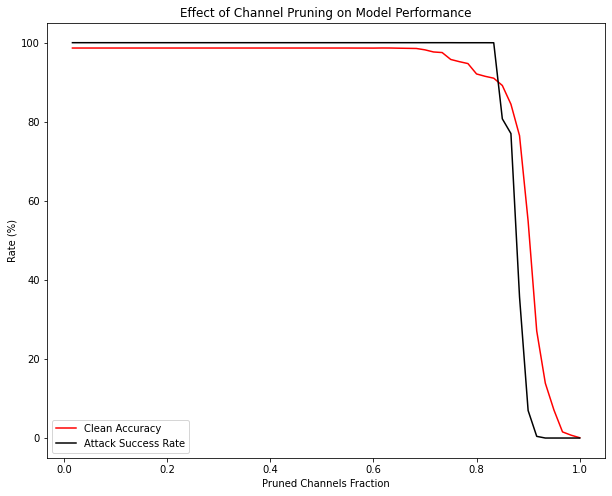

In [16]:
# Plotting figure
figure = plt.figure(figsize=(10, 8))

# Generate x-axis values representing the fraction of pruned channels
x_axis = np.arange(1, 61) / 60

# Plot the clean accuracy and attack success rate curves
plt.plot(x_axis, clean_accuracies, color='red', label='Clean Accuracy')
plt.plot(x_axis, attack_success_rates, color='black', label='Attack Success Rate')

# Add legend to the plot
plt.legend(['Clean Accuracy', 'Attack Success Rate'])

# Set labels for the x and y axes
plt.xlabel("Pruned Channels Fraction")
plt.ylabel("Rate (%)")

# Set the title of the plot
plt.title("Effect of Channel Pruning on Model Performance")

# Comments:
# - The x-axis values represent the fraction of pruned channels, ranging from 1/60 to 1.

# - A legend is added to differentiate between the clean accuracy and attack success rate curves.
# - Labels are set for the x and y axes to provide context to the plot.
# - The title of the plot summarizes the information being visualized.


The clean_accuracies list is plotted in red, representing the clean classification accuracy and The attack_success_rates list is plotted in black, representing the attack success rate.

In [17]:
# Find indices where clean accuracy drops by at least 30%
indices_accuracy_drop = np.where(np.array(clean_accuracies) <= (clean_data_accuracy - 30))[0]

# Extract the corresponding attack success rate at the first index
asr_at_accuracy_drop = attack_success_rates[indices_accuracy_drop[0]]

# Print the attack success rate when accuracy drops by at least 30%
print("Attack Success Rate with at least 30% drop in Clean Accuracy:", asr_at_accuracy_drop)

# Comments:

# - The print statement reflects the intention more clearly by specifying the context of the accuracy drop.

Attack Success Rate with at least 30% drop in Clean Accuracy: 6.954187234779596


indices_accuracy_drop contains the indices where clean accuracy drops by at least 30%.
asr_at_accuracy_drop stores the corresponding attack success rate at the first index.

In [18]:
class G(keras.Model):
    def __init__(self, model_B, model_B_prime):
        super(G, self).__init__()
        self.model_B = model_B
        self.model_B_prime = model_B_prime

    def predict(self, input_data):
        # Get predictions from model B
        predictions_B = np.argmax(self.model_B(input_data), axis=1)

        # Get predictions from model B_prime
        predictions_B_prime = np.argmax(self.model_B_prime(input_data), axis=1)

        # Initialize an array to store final predictions
        final_predictions = np.zeros(input_data.shape[0])

        # Compare predictions from B and B_prime
        for i in range(input_data.shape[0]):
            if predictions_B[i] == predictions_B_prime[i]:
                final_predictions[i] = predictions_B[i]
            else:
                final_predictions[i] = 1283  # Use 1283 as a special value for inconsistent predictions

        return final_predictions


- The class G is defined, representing a model that compares predictions from two other models (B and B_prime).
- The predict method calculates predictions from B and B_prime, compares them, and generates final predictions.

In [19]:
# Filepaths for the test data
clean_test_data_filepath = r'test.h5'
poisoned_test_data_filepath = r'bd_test.h5'

# Filepaths for different models
model_X_2_filepath = 'model_X=2.h5'
model_X_4_filepath = 'model_X=4.h5'
model_X_10_filepath = 'model_X=10.h5'

In [20]:
# Load the model saved when the accuracy drops by at least 2%
loaded_model_X_2 = keras.models.load_model(model_X_2_filepath)

# Load the model saved when the accuracy drops by at least 4%
loaded_model_X_4 = keras.models.load_model(model_X_4_filepath)

# Load the model saved when the accuracy drops by at least 10%
loaded_model_X_10 = keras.models.load_model(model_X_10_filepath)

In [21]:
# Load the clean test data
loaded_clean_test_data, loaded_clean_test_labels = load_data(clean_test_data_filepath)

# Load the poisoned test data
loaded_poisoned_test_data, loaded_poisoned_test_labels = load_data(poisoned_test_data_filepath)

# Print the shape of the loaded clean test data
print("Shape of loaded_clean_test_data:", loaded_clean_test_data.shape)

# Print the shape of the loaded poisoned test data
print("Shape of loaded_poisoned_test_data:", loaded_poisoned_test_data.shape)

Shape of loaded_clean_test_data: (12830, 55, 47, 3)
Shape of loaded_poisoned_test_data: (12830, 55, 47, 3)


In [27]:
# Create an instance of the G class with model and the model saved when accuracy drops by at least 2%
g_model_x_2 = G(badnet_model, loaded_model_X_2)

# Create an instance of the G class with model and the model saved when accuracy drops by at least 4%
g_model_x_4 = G(badnet_model, loaded_model_X_4)

# Create an instance of the G class with model and the model saved when accuracy drops by at least 10%
g_model_x_10 = G(badnet_model, loaded_model_X_10)

In [31]:
# Predictions and evaluation for the model saved when accuracy drops by 2%
cl_test_2_predictions = np.argmax(loaded_model_X_2.predict(loaded_clean_test_data), axis=1)
cl_test_2_accuracy = np.mean(np.equal(cl_test_2_predictions, loaded_clean_test_labels)) * 100
print('2% Accuracy Drop Model - ')
print('Clean Test Data Classification Accuracy:', cl_test_2_accuracy)

bd_test_2_predictions = np.argmax(loaded_model_X_2.predict(loaded_poisoned_test_data), axis=1)
attack_success_rate_2 = np.mean(np.equal(bd_test_2_predictions, loaded_poisoned_test_labels)) * 100
print('Attack Success Rate:', attack_success_rate_2)
print()

401/401 [==============================] - 2s 4ms/step
2% Accuracy Drop Model - 
Clean Test Data Classification Accuracy: 95.90023382696803
401/401 [==============================] - 2s 5ms/step
Attack Success Rate: 100.0



In [32]:
# Predictions and evaluation for the model saved when accuracy drops by 4%
cl_test_4_predictions = np.argmax(loaded_model_X_4.predict(loaded_clean_test_data), axis=1)
cl_test_4_accuracy = np.mean(np.equal(cl_test_4_predictions, loaded_clean_test_labels)) * 100
print('4% Accuracy Drop Model -')
print('Clean Test Data Classification Accuracy:', cl_test_4_accuracy)

bd_test_4_predictions = np.argmax(loaded_model_X_4.predict(loaded_poisoned_test_data), axis=1)
attack_success_rate_4 = np.mean(np.equal(bd_test_4_predictions, loaded_poisoned_test_labels)) * 100
print('Attack Success Rate:', attack_success_rate_4)
print()

401/401 [==============================] - 2s 5ms/step
4% Accuracy Drop Model -
Clean Test Data Classification Accuracy: 92.29150428682775
401/401 [==============================] - 2s 5ms/step
Attack Success Rate: 99.98441153546376



In [33]:
# Predictions and evaluation for the model saved when accuracy drops by 10%
cl_test_10_predictions = np.argmax(loaded_model_X_10.predict(loaded_clean_test_data), axis=1)
cl_test_10_accuracy = np.mean(np.equal(cl_test_10_predictions, loaded_clean_test_labels)) * 100
print('10% Accuracy Drop Model -')
print('Clean Test Data Classification Accuracy:', cl_test_10_accuracy)

bd_test_10_predictions = np.argmax(loaded_model_X_10.predict(loaded_poisoned_test_data), axis=1)
attack_success_rate_10 = np.mean(np.equal(bd_test_10_predictions, loaded_poisoned_test_labels)) * 100
print('Attack Success Rate:', attack_success_rate_10)
print()

401/401 [==============================] - 2s 5ms/step
10% Accuracy Drop Model -
Clean Test Data Classification Accuracy: 84.54403741231489
401/401 [==============================] - 2s 5ms/step
Attack Success Rate: 77.20966484801247



In [46]:
# Accuracy and Attack Rate for different repaired models
repaired_test_accuracies = [cl_test_2_accuracy, cl_test_4_accuracy, cl_test_10_accuracy]
repaired_attack_rates = [attack_success_rate_2, attack_success_rate_4, attack_success_rate_10]

# Data for creating a DataFrame
repaired_model_data = {
    "Test Data Classification Accuracy": repaired_test_accuracies,
    "Attack Rate": repaired_attack_rates,
    "Repaired Model": ["Repaired_2%", "Repaired_4%", "Repaired_10%"]
}

# Create a DataFrame from the repaired model data
repaired_model_df = pd.DataFrame(repaired_model_data)

# Set the index of the DataFrame to the "Repaired Model" column
repaired_model_df.set_index('Repaired Model', inplace=True)
print(repaired_model_df)

                Test Data Classification Accuracy  Attack Rate
Repaired Model                                                
Repaired_2%                             95.900234   100.000000
Repaired_4%                             92.291504    99.984412
Repaired_10%                            84.544037    77.209665


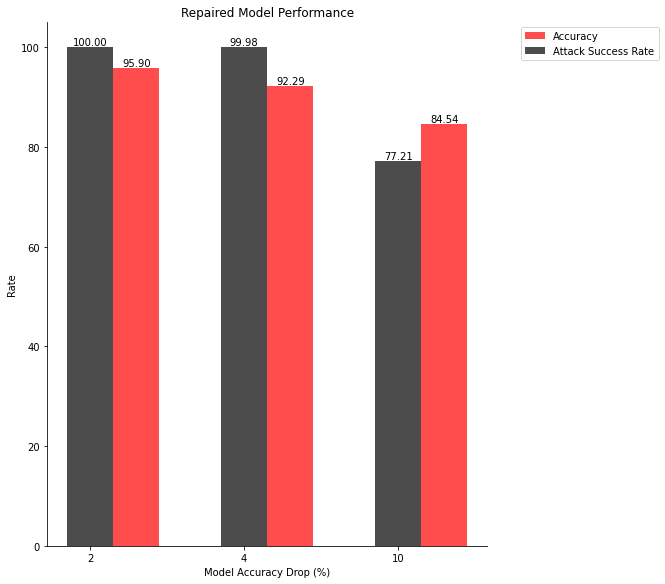

In [35]:
# Plotting parameters
opacity = 0.7
bar_width = 0.3

# Create a figure for plotting
figure = plt.figure(figsize=(10, 8))

# Set labels for the x and y axes
plt.xlabel('Model Accuracy Drop (%)')
plt.ylabel('Rate')

# Define x-axis ticks and labels
accuracy_drop_percentages = ['2', '4', '10']
plt.xticks(range(len(repaired_test_accuracies)), accuracy_drop_percentages)

# Create bar plots for accuracy and attack rate
bar1 = plt.bar(np.arange(len(repaired_test_accuracies)) + bar_width, repaired_test_accuracies, bar_width,
               align='center', alpha=opacity, color='red', label='Accuracy')
bar2 = plt.bar(range(len(repaired_attack_rates)), repaired_attack_rates, bar_width,
               align='center', alpha=opacity, color='black', label='Attack Success Rate')

# Add counts above the two bar graphs
for rect in bar1 + bar2:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2.0, height, f'{height:.02f}', ha='center', va='bottom')

# Add legend outside the plot
plt.legend(bbox_to_anchor=(1.4, 1))

# Adjust layout for better display
plt.tight_layout()

# Set the title of the plot
plt.title('Repaired Model Performance')

sns.despine()

# Show the plot
plt.show()

In [38]:
# Predictions and evaluation for the combined model using G with the model saved when accuracy drops by 2%
combined_cl_test_2_predictions = g_model_x_2.predict(loaded_clean_test_data)
combined_cl_test_2_accuracy = np.mean(np.equal(combined_cl_test_2_predictions, loaded_clean_test_labels)) * 100
print('Combined 2% Accuracy Drop Model - Clean Test Data Classification Accuracy:', combined_cl_test_2_accuracy)

combined_bd_test_2_predictions = g_model_x_2.predict(loaded_poisoned_test_data)
combined_asr_2 = np.mean(np.equal(combined_bd_test_2_predictions, loaded_poisoned_test_labels)) * 100
print('Combined 2% Accuracy Drop Model - Attack Success Rate:', combined_asr_2)

Combined 2% Accuracy Drop Model - Clean Test Data Classification Accuracy: 95.74434918160561
Combined 2% Accuracy Drop Model - Attack Success Rate: 100.0


In [40]:
# Predictions and evaluation for the combined model using G with the model saved when accuracy drops by 4%
combined_cl_test_4_predictions = g_model_x_4.predict(loaded_clean_test_data)
combined_cl_test_4_accuracy = np.mean(np.equal(combined_cl_test_4_predictions, loaded_clean_test_labels)) * 100
print('Combined 4% Accuracy Drop Model - Clean Test Data Classification Accuracy:', combined_cl_test_4_accuracy)

combined_bd_test_4_predictions = g_model_x_4.predict(loaded_poisoned_test_data)
combined_asr_4 = np.mean(np.equal(combined_bd_test_4_predictions, loaded_poisoned_test_labels)) * 100
print('Combined 4% Accuracy Drop Model - Attack Success Rate:', combined_asr_4)

Combined 4% Accuracy Drop Model - Clean Test Data Classification Accuracy: 92.1278254091972
Combined 4% Accuracy Drop Model - Attack Success Rate: 99.98441153546376


In [41]:
# Predictions and evaluation for the combined model using G with the model saved when accuracy drops by 10%
combined_cl_test_10_predictions = g_model_x_10.predict(loaded_clean_test_data)
combined_cl_test_10_accuracy = np.mean(np.equal(combined_cl_test_10_predictions, loaded_clean_test_labels)) * 100
print('Combined 10% Accuracy Drop Model - Clean Test Data Classification Accuracy:', combined_cl_test_10_accuracy)

combined_bd_test_10_predictions = g_model_x_10.predict(loaded_poisoned_test_data)
combined_asr_10 = np.mean(np.equal(combined_bd_test_10_predictions, loaded_poisoned_test_labels)) * 100
print('Combined 10% Accuracy Drop Model - Attack Success Rate:', combined_asr_10)

Combined 10% Accuracy Drop Model - Clean Test Data Classification Accuracy: 84.3335931410756
Combined 10% Accuracy Drop Model - Attack Success Rate: 77.20966484801247


In [45]:
# Accuracy and Attack Rate for the combined models using G
combined_G_test_accuracies = [combined_cl_test_2_accuracy, combined_cl_test_4_accuracy, combined_cl_test_10_accuracy]
combined_G_attack_rates = [combined_asr_2, combined_asr_4, combined_asr_10]

# Data for creating a DataFrame for the combined models using G
combined_G_model_data = {
    "G Test Accuracy": combined_G_test_accuracies,
    "G Attack Success Rate": combined_G_attack_rates,
    "G Model": ["G_2%", "G_4%", "G_10%"]
}

# Create a DataFrame for the combined models using G
combined_G_df = pd.DataFrame(combined_G_model_data)

# Set the index of the DataFrame to the "G Model" column
combined_G_df.set_index('G Model', inplace=True)
print(combined_G_df)

         G Test Accuracy  G Attack Success Rate
G Model                                        
G_2%           95.744349             100.000000
G_4%           92.127825              99.984412
G_10%          84.333593              77.209665


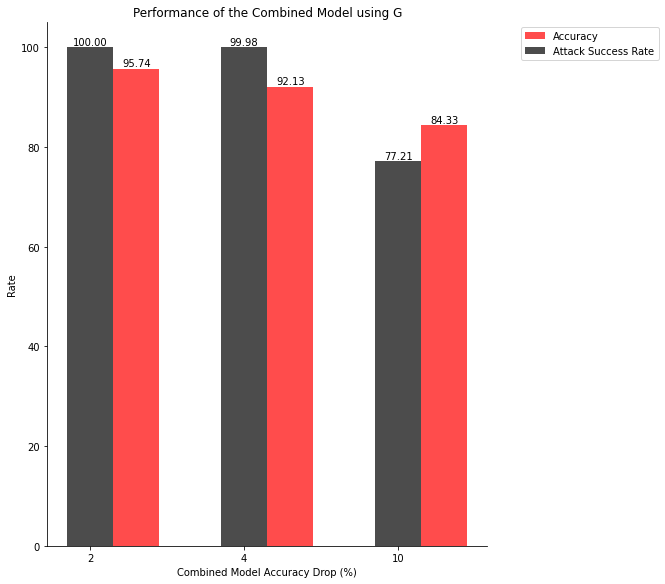

In [43]:
# Plotting parameters
opacity = 0.7
bar_width = 0.3

# Create a figure for plotting
figure = plt.figure(figsize=(10, 8))

# Set labels for the x and y axes
plt.xlabel('Combined Model Accuracy Drop (%)')
plt.ylabel('Rate')

# Define x-axis ticks and labels
combined_model_accuracy_drops = ['2', '4', '10']
plt.xticks(range(len(combined_G_test_accuracies)), combined_model_accuracy_drops)

# Create bar plots for accuracy and attack rate
bar1 = plt.bar(np.arange(len(combined_G_test_accuracies)) + bar_width, combined_G_test_accuracies, bar_width,
               align='center', alpha=opacity, color='red', label='Accuracy')
bar2 = plt.bar(range(len(combined_G_attack_rates)), combined_G_attack_rates, bar_width,
               align='center', alpha=opacity, color='black', label='Attack Success Rate')

# Add counts above the two bar graphs
for rect in bar1 + bar2:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2.0, height, f'{height:.02f}', ha='center', va='bottom')

plt.legend(bbox_to_anchor=(1.4, 1))
plt.tight_layout()

# Set the title of the plot
plt.title('Performance of the Combined Model using G')

sns.despine()

# Show the plot
plt.show()